# 3115 - Lab Programming Machine Learning

## Lab Exercise 8 Bonus

## Yuvaraj Prem Kumar, 303384

In [4]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

In [5]:
# Importing sklearn libraries
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.model_selection import train_test_split

In [6]:
# Importing Pytorch libraries
import torch
import torch.nn as nn
print("PyTorch Version %s" %torch.__version__)

PyTorch Version 1.3.1


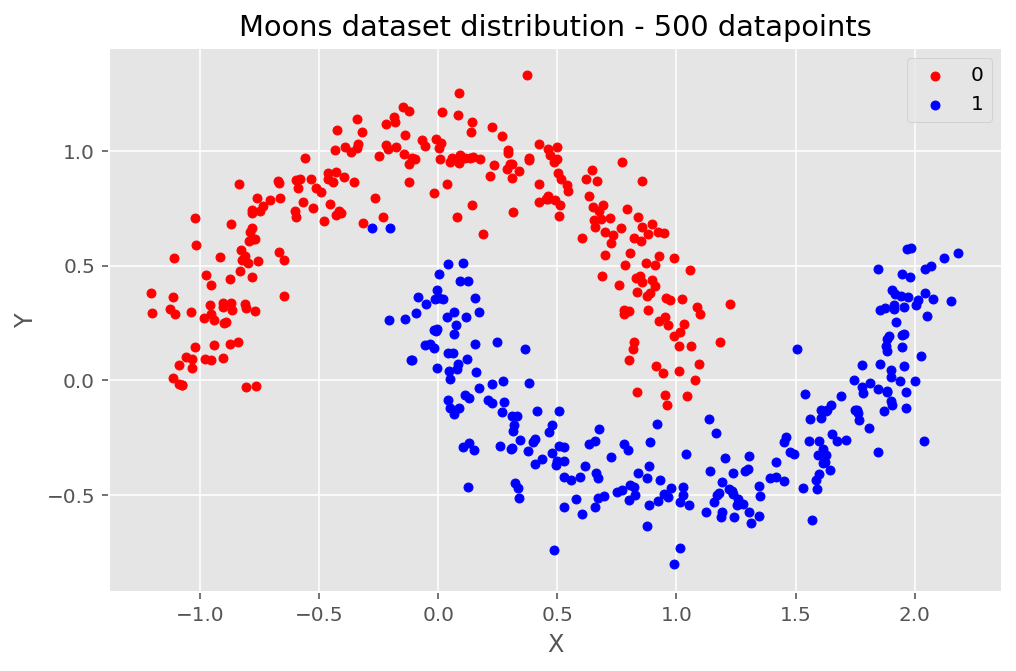

In [7]:
# Generate moons dataset [1]
np.random.seed(19)
X, y = sklearn.datasets.make_moons(500, noise=0.10)

df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))

# Plotting the data distribution
fig, ax = plt.subplots(figsize=(8,5))
grouped = df.groupby('label')
colors = {0:'red', 1:'blue'}
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
ax.set_title("Moons dataset distribution - 500 datapoints")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=73)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((375, 2), (375,), (125, 2), (125,))

The data generated cannot be separated by a single straight line, so a single perceptron cannot be used to correctly classify this data to its labels. Hence we implement a multi-layer perceptron for the classification.

The following parameters are used for both the Numpy and PyTorch implementation:

* Learning rate = 0.1 (arbitrarily chosen after trial and error)
* Iterations = 10000
* 2 hidden layers, with 4 neurons each
* Output layer consisting of one neuron

For weights initialization, we are using Xavier initializer [2]. The weights are then selected from a uniform distribution from [-c, c].

\begin{equation}
c=\sqrt{\frac{3}{\frac{1}{2}(n_{in}+n_{out})}}
\end{equation}

And the bias is simply intialized with zeros.

## Part A: Implementing Artificial Neural Network (ANN) from scratch

The algorithm for a neural network is given as:

<img src="https://i.imgur.com/8EIq7uW.jpg" width="45%"/>

The network architecture consists of:
* 1 input layer
* 2 hidden layers (4 neurons each)
* 1 output layer

We have two class labels to predict / classify: [0, 1]. We use a sigmoid activation function for class predictions, because it returns values between 0 and 1 which is the labels we want to predict. After hidden layer 1 and 2, ReLU activation function is applied on the output. 

For manual calculations, derivations for feedforward and backpropagation, and detailed explanations, please refer to the attached pdf file: **"Lab8_Bonus_calculations.pdf"**.

In [83]:
class learn_nn_sgd():
    
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.n_inputs = X.shape[0]
        self.n_input_dim = X.shape[1]
        self.n_output_dim = 1
        
        
    def initialize(self, n_hidden, seed=1):
        self.n_hidden = n_hidden
        np.random.seed(seed)
        c = np.sqrt(3 / (0.5 + self.n_input_dim + self.n_output_dim))
        
        W1 = np.random.uniform(low=-c, high=c, size=(2, 4))
        b1 = np.zeros((1, 4))

        W2 = np.random.uniform(low=-c, high=c,size=(4, 4))
        b2 = np.zeros((1, 4))

        W3 = np.random.uniform(low=-c, high=c,size=(4, 1))
        b3 = np.zeros((1, 1))
        
        self.params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
        self.cache = {}
        
        
    def relu(self, x):
        return np.maximum(0, x)
    
    
    def d_relu(self, x):
        '''ReLU derivative from [4]
        '''
        return np.greater(x, 0).astype(int)
        
    
    def sigmoid(self, x):
        return 1. / (1 + np.exp(-x))
    
    
    def forward_prop(self, X=None, cache=True):
        
        W1 = self.params['W1']
        b1 = self.params['b1']
        W2 = self.params['W2']
        b2 = self.params['b2']
        W3 = self.params['W3']
        b3 = self.params['b3']
        
        if X is None:
            X = self.X.copy()
        
        Z1 = np.dot(X, W1) + b1
        A1 = self.relu(Z1)
        
        Z2 = np.dot(A1, W2) + b2
        A2 = self.relu(Z2)
        
        Z3 = np.dot(A2, W3) + b3
        A3 = self.sigmoid(Z3)

        yhat = A3
        
        if cache:
            self.cache = {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2, 'Z3': Z3, 'A3': A3, 'yhat': yhat} 
        else:
            return yhat
    
    
    def back_prop(self):
        
        # Import parameters and cached values
        A1 = self.cache['A1']
        A2 = self.cache['A2']
        A3 = self.cache['A3']
        
        Z1 = self.cache['Z1']
        Z2 = self.cache['Z2']
        Z3 = self.cache['Z3']
        
        W1 = self.params['W1']
        b1 = self.params['b1']
        
        W2 = self.params['W2']
        b2 = self.params['b2']
        
        W3 = self.params['W3']
        b3 = self.params['b3']
        
        # Calculate derivatives
        m = 1 / self.n_inputs  # regularization factor (N_examples) to smoothen output during backpropagation
        
        dZ3 = A3 - self.Y.reshape(-1,1)
        dW3 = m * np.dot(A2.T, dZ3)
        db3 = m * np.sum(dZ3, axis=0, keepdims=True)


        dZ2 = m * np.dot(dZ3, W3.T) * self.d_relu(Z2)
        dW2 = m * np.dot(A1.T, dZ2)
        db2 = m * np.sum(dZ2, axis=0, keepdims=True)

        dZ1 = m * np.dot(dZ2, W2.T) * self.d_relu(Z1)
        dW1 = m * np.dot(self.X.T, dZ1)
        db1 = m * np.sum(dZ1, axis=0)
        
        # Apply gradient descent updates
        W1 -= self.learning_rate * dW1
        b1 -= self.learning_rate * db1
        
        W2 -= self.learning_rate * dW2
        b2 -= self.learning_rate * db2
        
        W3 -= self.learning_rate * dW3
        b3 -= self.learning_rate * db3
        
        # Store updated network parameters
        self.params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
        
        
    def train(self, learning_rate=0.05, n_iters=10000, log_loss=False):
        
        self.learning_rate = learning_rate
        loss = []
        
        # Train the network
        for i in range(n_iters):
            self.forward_prop()
            self.back_prop()
            
            # Calculate the loss value to track progress
            if log_loss:
                loss.append(self.calculate_loss())
                
        if log_loss:
            return loss
    
    
    def predict(self, X):
        '''For prediction on test data, its basically classifying the calculated output into labels or 0 or 1
        '''
        yhat = self.forward_prop(X, cache=False)
        return np.where(yhat < 0.5, 0, 1)
    
    
    def calculate_loss(self):
        yhat = self.cache['yhat']
        W1 = self.params['W1']
        W2 = self.params['W2']
        W3 = self.params['W3']
        
        Y = self.Y.reshape(-1,1)
        loss = (np.multiply(np.log(yhat), Y) + np.multiply(np.log(1 - yhat), (1 - Y)))
        return -1 / self.n_inputs * np.sum(loss)
    
    
    def train_accuracy(self):
        yhat = self.cache['yhat']
        clf = np.where(yhat < 0.5, 0, 1)
        return np.sum(self.Y.reshape(-1, 1)==clf) / self.n_inputs
    

    def plot_decision_boundary(self):
        
        # Determine grid range in x and y directions
        x_min, x_max = self.X[:, 0].min()-0.1, self.X[:, 0].max()+0.1
        y_min, y_max = self.X[:, 1].min()-0.1, self.X[:, 1].max()+0.1
   
        # Set grid spacing parameter
        spacing = min(x_max - x_min, y_max - y_min) / 100

        # Create grid
        XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing), np.arange(y_min, y_max, spacing))
    
        # Concatenate data to match input
        data = np.hstack((XX.ravel().reshape(-1,1), YY.ravel().reshape(-1,1)))

        # Pass data to predict method
        clf = self.predict(data)
    
        Z = clf.reshape(XX.shape)
        
        plt.figure(figsize=(8,5))
        plt.title('Decision Boundary')
        plt.contourf(XX, YY, Z, cmap=plt.cm.Spectral, alpha=0.8)
        plt.scatter(self.X[:,0], self.X[:,1], cmap=plt.cm.Spectral,  c=self.Y, s=50)
        plt.show()
    


In [84]:
net = learn_nn_sgd(X_train, y_train)
net.initialize(n_hidden = 4)

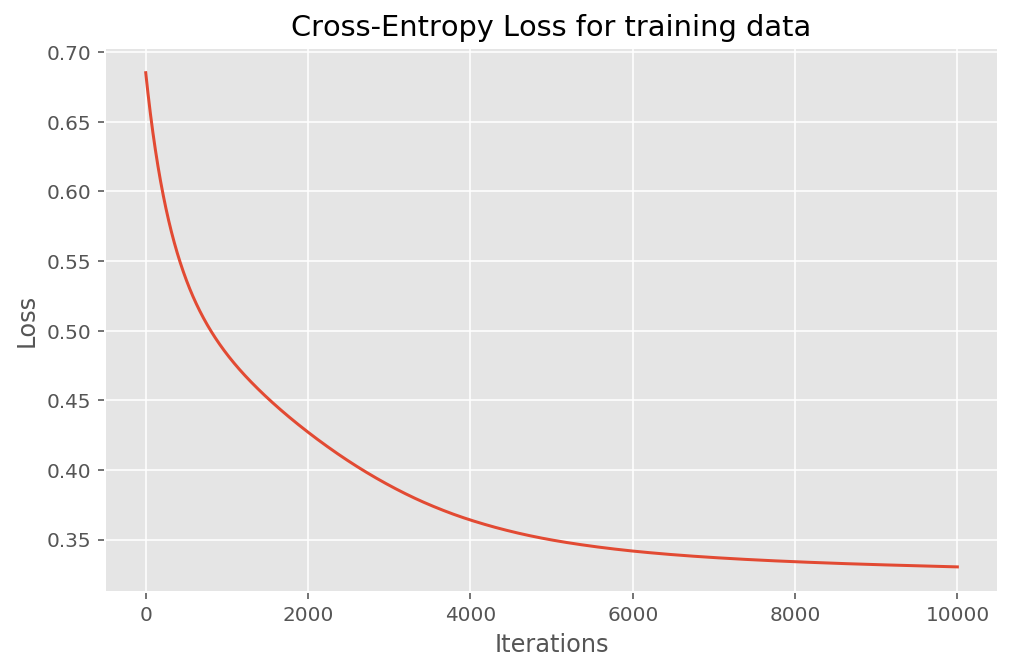

Training Accuracy: 0.84

Model training execution time:
--- 5.29473 seconds ---


In [85]:
# Timing the training code block, [3]
start_time = time.time()

# Training phase
training_loss = net.train(learning_rate=0.1, log_loss=True)

plt.figure(figsize=(8,5))
plt.plot(training_loss)
plt.title("Cross-Entropy Loss for training data")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

print("Training Accuracy: %.2f" %net.train_accuracy())

print('\nModel training execution time:')
print("--- %s seconds ---" % np.round((time.time() - start_time),5))

In [86]:
# Making predictions on test set, and calculating the accuracy score vs ground truth
pred = net.predict(X_test)
accuracy_score = np.sum(y_test.reshape(-1,1) == pred) / len(y_test)

print("Test Accuracy: %.2f" %accuracy_score)

Test Accuracy: 0.86


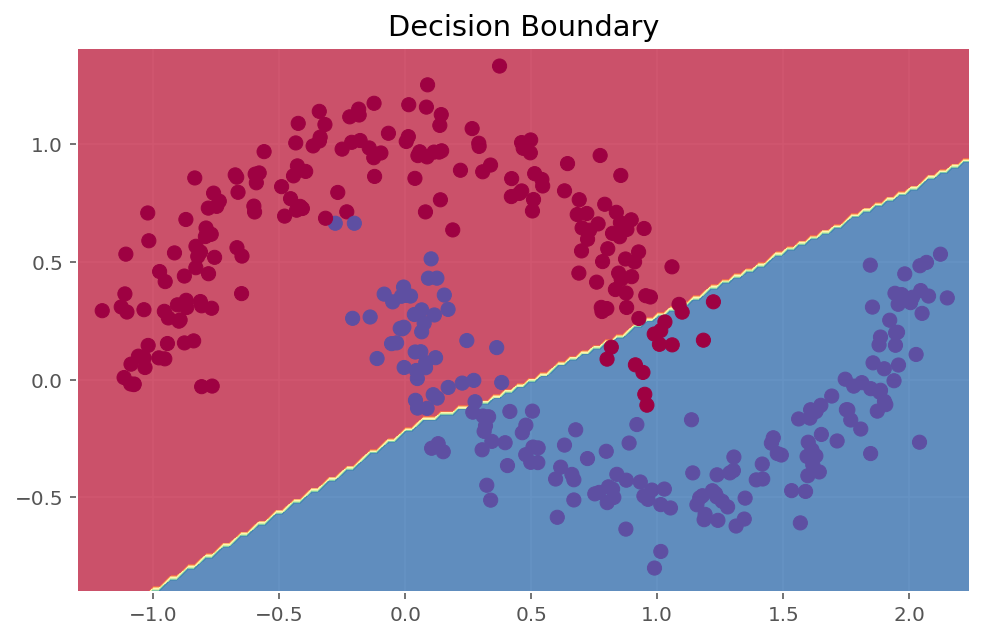

In [87]:
# Plotting the decision boundary
net.plot_decision_boundary()

# Part B: Neural Network with PyTorch

Now we implement the same code in Part A using PyTorch. The main reference used is from [5].

In [74]:
class learn_nn_sgd2():
    
    def __init__(self, X, Y, n_hidden=4, learning_rate=0.1, device='cpu'):
        self.device = device
        self.X = X
        self.Y = Y.reshape(-1,1)
        self.Y_t = torch.FloatTensor(self.Y).to(device=self.device)
        self.n_input_dim = X.shape[1]
        self.n_output = 1
        self.learning_rate = learning_rate
        self.n_hidden = n_hidden
        
        # Build network
        self.net = nn.Sequential(
            nn.Linear(self.n_input_dim, self.n_hidden), 
            nn.ReLU(),
            nn.Linear(self.n_hidden, self.n_hidden), 
            nn.ReLU(),
            nn.Linear(self.n_hidden, self.n_output),
            nn.Sigmoid()
        )
        
        self.loss_func = nn.BCELoss()  # binary_cross_entropy loss, suitable for the class labels we want to predict
        self.optimizer = torch.optim.SGD(self.net.parameters(), lr=self.learning_rate)
        
    def predict(self, X):
        X_t = torch.FloatTensor(X).to(device=self.device)
        return self.net(X_t)
    
    def calculate_loss(self, y_hat):
        return self.loss_func(y_hat, self.Y_t)
    
    def backprop(self, y_hat):
        self.optimizer.zero_grad() 
        loss = self.calculate_loss(y_hat)
        loss.backward() 
        self.optimizer.step()
        self.training_loss.append(loss.item())
        
    def calculate_accuracy(self, y_hat_class, Y):
        return np.sum(Y.reshape(-1,1)==y_hat_class) / len(Y)
        
    def train(self, n_iters=10000):
        self.training_loss = []
        self.training_accuracy = []
        
        for i in range(n_iters):
            y_hat = self.predict(self.X)
            self.backprop(y_hat)
            y_hat_class = np.where(y_hat<0.5, 0, 1)
            accuracy = self.calculate_accuracy(y_hat_class, self.Y)
            self.training_accuracy.append(accuracy)
                     
    def plot_training_results(self):
        fig, ax = plt.subplots(1, 2, figsize=(15,5))
        ax[0].plot(self.training_loss)
        ax[0].set_ylabel('Loss')
        ax[0].set_xlabel('Iterations')
        ax[0].set_title('Training Loss')

        ax[1].plot(self.training_accuracy)
        ax[1].set_ylabel('Classification Accuracy')
        ax[1].set_xlabel('Iterations')
        ax[1].set_title('Training Accuracy')

        plt.tight_layout()
        plt.show()
        
    def plot_decision_boundary(self, X_test, Y_test):

        # Plot the decision boundary
        x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
        y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
        spacing = min(x_max - x_min, y_max - y_min) / 100

        XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing), np.arange(y_min, y_max, spacing))

        data = np.hstack((XX.ravel().reshape(-1,1), YY.ravel().reshape(-1,1)))

        # Pass data to predict method
        db_prob = self.predict(data)
        clf = np.where(db_prob<0.5,0,1)
        Z = clf.reshape(XX.shape)
        
        plt.figure(figsize=(8,5))
        plt.title('Decision Boundary')
        plt.contourf(XX, YY, Z, cmap=plt.cm.Spectral, alpha=0.5)
        plt.scatter(X_test[:,0], X_test[:,1], c=Y_test, cmap=plt.cm.Spectral)
        plt.show()
        

In [75]:
net2 = learn_nn_sgd2(X_train, y_train)
print(net2.net)

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)


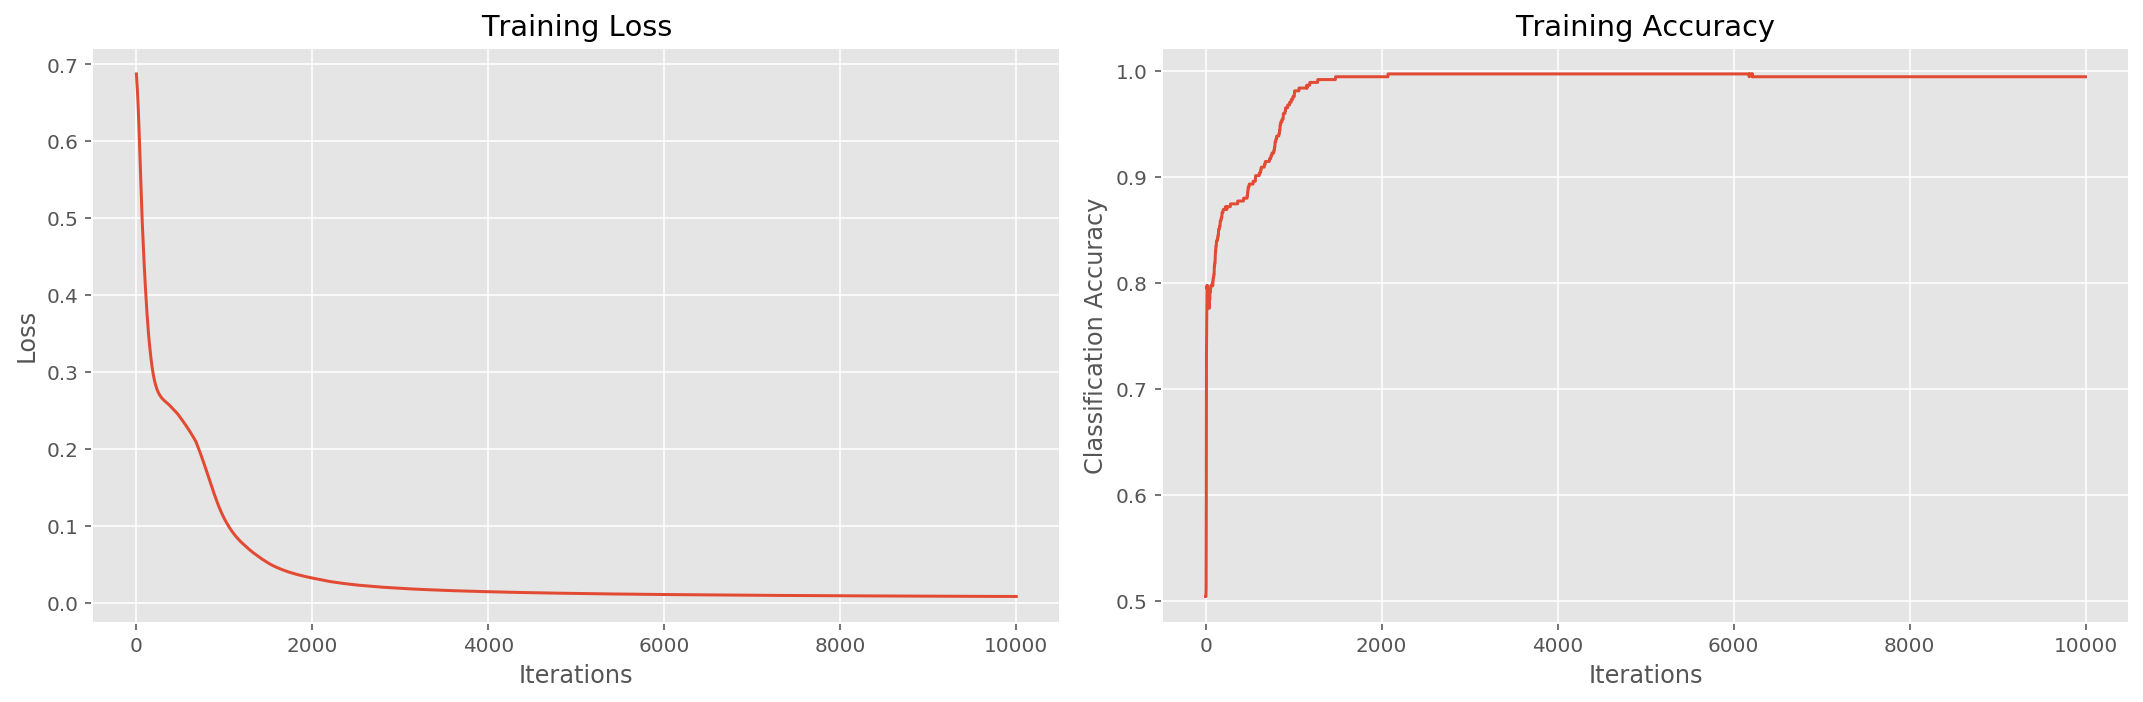


PyTorch Model training execution time:
--- 18.75335 seconds ---


In [76]:
# Timing the training code block, [3]
start_time = time.time()

# Training phase
net2.train()
net2.plot_training_results()

print('\nPyTorch Model training execution time:')
print("--- %s seconds ---" % np.round((time.time() - start_time),5))

In [77]:
# Making predictions on test set, and calculating the accuracy score vs ground truth
y_hat_test = net2.predict(X_test)
pred = np.where(y_hat_test<0.5, 0, 1)
accuracy_score = np.sum(y_test.reshape(-1,1) == pred) / len(y_test)

print("Test Accuracy: %.2f" %accuracy_score)

Test Accuracy: 1.00


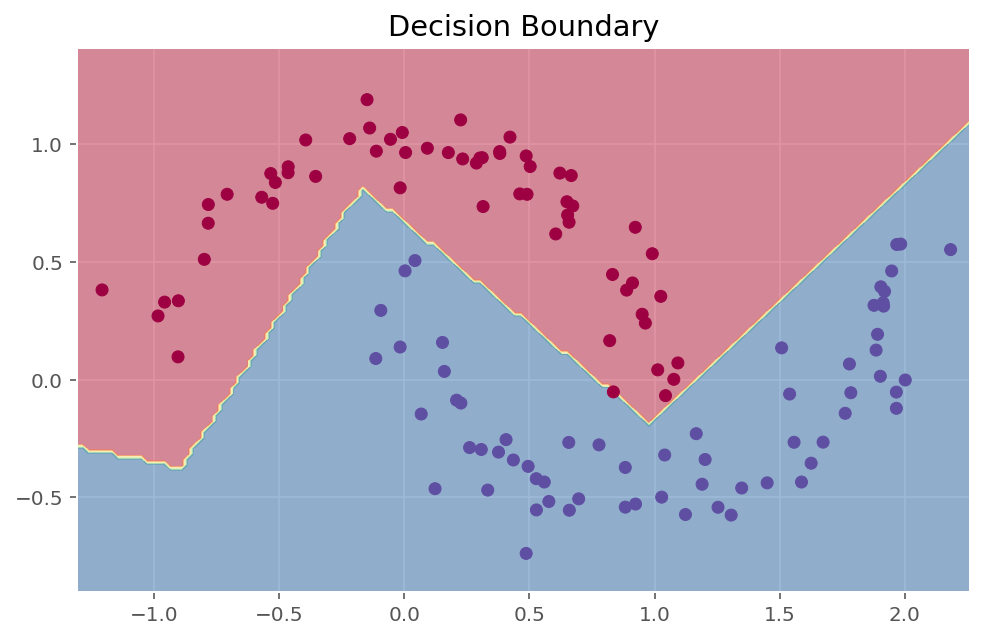

In [78]:
net2.plot_decision_boundary(X_test, y_test)

## Summary
1. The PyTorch model takes three times longer than the Numpy version (18.75335 seconds versus 5.01832 seconds). This is to be expected as there is some overhead time in initializing the variables. Also the numpy implementation is basically combinations of numpy multiply. I also used batch gradient descent for the numpy model, as SGD implementation encounters log zero warnings (which is avoided / handled automatically in PyTorch).
2. However the difference is clear in the accuracy achieved on the test set. In fact I did not expect to reach 100% accuracy on both train and test in the PyTorch model - but it can be expected since this dataset is fairly simple and neatly distributed.
3. I found that using only one hidden layer actually gives a very high accuracy (90%) and a good decision boundary showing a clear split. Since the problem to be solved is not so complex, we should not need two hidden layers actually.

# References

[1] https://machinelearningmastery.com/generate-test-datasets-python-scikit-learn/ <br>
[2] https://www.datahubbs.com/deep-learning-101-building-a-neural-network-from-the-ground-up/ <br>
[3] https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution <br>
[4] https://stackoverflow.com/questions/46411180/implement-relu-derivative-in-python-numpy/46411340 <br>
[5] https://www.datahubbs.com/deep-learning-101-first-neural-network-with-pytorch/ <br>
